In this, the MLP head is added and only the head is trained on the data, while the transformer block are kept frozen. 

Resulting in giving about 89-90% test accuracy

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install timm

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import timm

import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics
from shutil import copyfile

In [4]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

In [5]:
!ls "gdrive/MyDrive/Machine Vision and Image Processing/Project/Dataset"

Pollen_data.zip  test.zip  train.zip


In [6]:
!unzip -q "gdrive/MyDrive/Machine Vision and Image Processing/Project/Dataset/Pollen_data.zip"

replace Pollen_data/images/20190402172108_OBJ_4_1107_445.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## Loading the prepared Dataset

In [6]:
# general global variables
DATA_PATH = "Pollen_data"
IMAGES_PATH = "Pollen_data/images"

In [7]:
df = pd.read_csv(os.path.join(DATA_PATH, "data.csv"))
df.head()

,image_id,label
0,20190404111949_OBJ_0_1080_876.png,0
1,20190404110111_OBJ_27_393_106.png,0
2,20190404114349_OBJ_24_349_190.png,0
3,20190404112959_OBJ_33_841_184.png,0
4,20190404110146_OBJ_3_444_825.png,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11279 entries, 0 to 11278
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  11279 non-null  object
 1   label     11279 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 176.4+ KB


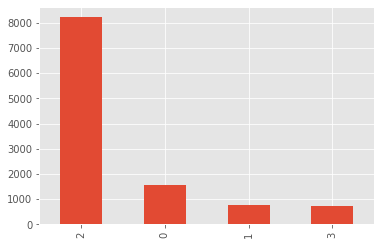

In [9]:
df.label.value_counts().plot(kind="bar")

In [10]:
# Here for splitting the data into train, test and validation. We will using train_test_split from sklearn

# First divide the data into train data (80%) and remaining data(20%)
# Secodn divide the remaining data into validation (10%) and test data(10%)
train_df, remaining_df = model_selection.train_test_split(df, test_size=0.2, random_state=42, stratify=df.label.values)

Text(0.5, 1.0, 'Training data distribution')

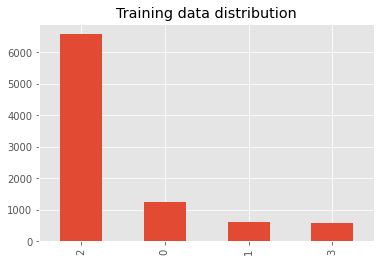

In [11]:
# Training data distribution
train_df.label.value_counts().plot(kind="bar")
plt.title("Training data distribution")

In [12]:
train_df.label.value_counts()

2    6573
0    1253
1     618
3     579
Name: label, dtype: int64

Text(0.5, 1.0, 'Except training data distribution')

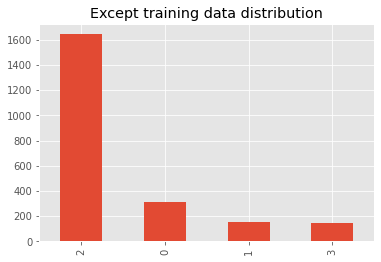

In [13]:
remaining_df.label.value_counts().plot(kind="bar")
plt.title("Except training data distribution")

In [14]:
valid_df, test_df = model_selection.train_test_split(remaining_df, test_size=0.5, random_state=42, stratify=remaining_df.label.values)

In [15]:
valid_df.label.value_counts()

2    821
0    156
1     78
3     73
Name: label, dtype: int64

Text(0.5, 1.0, 'Validation data distribution')

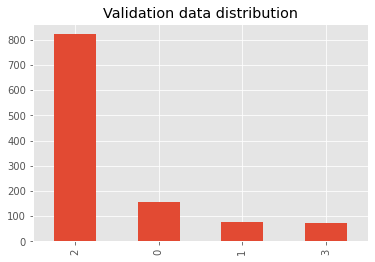

In [16]:
valid_df.label.value_counts().plot(kind="bar")
plt.title("Validation data distribution")

In [17]:
!ls "gdrive/MyDrive/Machine Vision and Image Processing/Project/pretrained_model"

jx_vit_base_p16_224-80ecf9dd.pth.zip


In [20]:
# Getting the pretrained transformer model into the current running environment
!unzip -q "gdrive/MyDrive/Machine Vision and Image Processing/Project/pretrained_model/jx_vit_base_p16_224-80ecf9dd.pth.zip"

In [18]:
MODEL_PATH = ("jx_vit_base_p16_224-80ecf9dd.pth")


# model specific global variables
IMG_SIZE = 224
BATCH_SIZE = 16

In [19]:
DATA_PATH

'Pollen_data'

In [20]:
len(df.values)

11279

In [27]:
from torch.utils.data import DataLoader
class PollenDataset(torch.utils.data.Dataset):
    """
    Helper Class to create the pytorch dataset
    """

    def __init__(self, df, data_path=DATA_PATH, transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.data_dir = "images"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        label = np.asarray(label, dtype='int64')

        if self.transforms is not None:
            image = self.transforms(img)

        return image, torch.from_numpy(label)
        # return img_name, label

In [28]:
# create image augmentations

transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [29]:
# Train and validation dataset with transformations
train_dataset = PollenDataset(train_df, transforms=transforms_train)
valid_dataset = PollenDataset(valid_df, transforms=transforms_valid)

In [30]:
# Train and validation loader 
train_loader = DataLoader(
     dataset=train_dataset,
     batch_size=BATCH_SIZE,
     shuffle = True
     )
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
    )

In [31]:
train_sample = iter(train_loader)
data, label = train_sample.next()
print(data.shape)
print(data.max())
print(data.min())

torch.Size([16, 3, 224, 224])
tensor(2.2318)
tensor(-2.0357)


In [32]:
data.dtype

torch.float32

In [ ]:
print("Available Vision Transformer Models: ")
timm.list_models("vit*")

In [33]:
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model("vit_base_patch16_224", pretrained=False)
        if pretrained:
            self.model.load_state_dict(torch.load(MODEL_PATH))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x   

In [29]:
model = ViTBase16(n_classes=4, pretrained=True)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
device

device(type='cuda')

In [32]:
from torchsummary import summary
model = model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
         LayerNorm-5             [-1, 197, 768]           1,536
            Linear-6            [-1, 197, 2304]       1,771,776
           Dropout-7         [-1, 12, 197, 197]               0
            Linear-8             [-1, 197, 768]         590,592
           Dropout-9             [-1, 197, 768]               0
        Attention-10             [-1, 197, 768]               0
         Identity-11             [-1, 197, 768]               0
        LayerNorm-12             [-1, 197, 768]           1,536
           Linear-13            [-1, 197, 3072]       2,362,368
             GELU-14            [-1, 19

In [33]:
pred = model(data.to(device))
pred

tensor([[ 0.1194, -0.3900,  0.1505, -0.5583],
        [-0.0322,  0.3261,  0.0498,  0.1794],
        [ 0.1753, -0.3765, -0.2668, -0.5543],
        [ 0.5268, -0.4686,  0.6782,  0.4360],
        [ 0.2178, -0.6117,  0.1143, -0.5424],
        [-0.1976, -0.3004,  0.1406,  0.2453],
        [-0.2154, -0.3759, -0.0427,  0.3615],
        [ 0.0050, -0.6890,  0.1830, -0.3861],
        [-0.7695, -0.0184, -0.3533,  0.0697],
        [-0.4051, -0.3870,  0.2043,  0.0884],
        [-0.4978, -0.7828, -0.1486,  0.3260],
        [ 0.5500, -0.1505,  0.2793, -0.3788],
        [-0.0877, -0.6342, -0.2530, -0.1161],
        [ 0.3461, -0.1894,  0.5625, -0.0810],
        [ 0.0796, -0.0666, -0.7042, -0.3583],
        [ 0.9054, -0.1226,  0.3087, -0.2903]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [36]:
label.shape

torch.Size([16])

In [37]:
pred.shape

torch.Size([16, 4])

In [39]:
criterion = nn.CrossEntropyLoss()
print(criterion(pred, label.to(device)))

tensor(1.2557, device='cuda:0', grad_fn=<NllLossBackward0>)


In [40]:
data[0].shape

torch.Size([3, 224, 224])

In [41]:
# Checking the model performance with out any training, on training set, so that we can 
# Conclude Later during that the model is atleast converging later on
baseline_train_loss = 0.0
baseline_train_accuracy = 0.0
criterion = nn.CrossEntropyLoss()
with torch.no_grad():
  model.eval()
  for data, target in train_loader:
    data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.int64)
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)

    # calculate the batch loss
    loss = criterion(output, target)
    
    # Calculate Accuracy
    accuracy = (output.argmax(dim=1) == target).float().mean()
    
    # update training loss and accuracy
    baseline_train_loss += loss
    baseline_train_accuracy += accuracy

In [42]:
print("Total training batches = {}".format(len(train_loader)))
print("Baseline Training Data Loss = {}".format(baseline_train_loss/len(train_loader)))
print("Baseline Training Data Accuracy = {} %".format(100*baseline_train_accuracy/len(train_loader)))

Total training batches = 564
Baseline Training Data Loss = 1.3190544843673706
Baseline Training Data Accuracy = 34.443702697753906 %


In [43]:
baseline_valid_loss = 0.0
baseline_valid_accuracy = 0.0
with torch.no_grad():
  model.eval()
  for data, target in valid_loader:
    data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.int64)
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)

    # calculate the batch loss
    loss = criterion(output, target)
    
    # Calculate Accuracy
    accuracy = (output.argmax(dim=1) == target).float().mean()
    
    # update training loss and accuracy
    baseline_valid_loss += loss
    baseline_valid_accuracy += accuracy

In [44]:
print("Total training batches = {}".format(len(valid_loader)))
print("Baseline Validation Data Loss = {}".format(baseline_valid_loss/len(valid_loader)))
print("Baseline Validation Data Accuracy = {} %".format(100*baseline_valid_accuracy/len(valid_loader)))

Total training batches = 71
Baseline Validation Data Loss = 1.3233730792999268
Baseline Validation Data Accuracy = 36.35563278198242 %


In [45]:
data[0].shape

torch.Size([3, 224, 224])

In [46]:
data.min()

tensor(-2.1179, device='cuda:0')

In [47]:
data.max()

tensor(2.1975, device='cuda:0')

In [48]:
for param in model.parameters():
  param.requires_grad = False

In [49]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
         LayerNorm-5             [-1, 197, 768]           1,536
            Linear-6            [-1, 197, 2304]       1,771,776
           Dropout-7         [-1, 12, 197, 197]               0
            Linear-8             [-1, 197, 768]         590,592
           Dropout-9             [-1, 197, 768]               0
        Attention-10             [-1, 197, 768]               0
         Identity-11             [-1, 197, 768]               0
        LayerNorm-12             [-1, 197, 768]           1,536
           Linear-13            [-1, 197, 3072]       2,362,368
             GELU-14            [-1, 19

In [50]:
counter = 1
for param in model.parameters():
  counter += 1
  if counter >= 150:
    param.requires_grad = True
  
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
         LayerNorm-5             [-1, 197, 768]           1,536
            Linear-6            [-1, 197, 2304]       1,771,776
           Dropout-7         [-1, 12, 197, 197]               0
            Linear-8             [-1, 197, 768]         590,592
           Dropout-9             [-1, 197, 768]               0
        Attention-10             [-1, 197, 768]               0
         Identity-11             [-1, 197, 768]               0
        LayerNorm-12             [-1, 197, 768]           1,536
           Linear-13            [-1, 197, 3072]       2,362,368
             GELU-14            [-1, 19

In [51]:
LR = 0.001
epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
check_every = 300
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
train_loss_array = []
train_acc_array = []
val_loss_array = []
val_acc_array = []
for epoch in range(epochs):
  epoch_loss = 0.0
  epoch_accuracy = 0.0
  i = 1
  for data, target in train_loader:
    model.train()
    data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.int64)
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # Calculate Accuracy
    accuracy = (output.argmax(dim=1) == target).float().mean()
    # update training loss and accuracy
    epoch_loss += loss
    epoch_accuracy += accuracy
    optimizer.step()
    i += 1
    if i % check_every == 0:
      
      # keep track of validation loss
      valid_loss = 0.0
      valid_accuracy = 0.0
      print("######### Into Validation Step ########")
      ######################
      # validate the model #
      ######################
      with torch.no_grad():
        model.eval()
        for data, target in valid_loader:
          # move tensors to GPU if CUDA is available
          data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.int64)
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          # calculate the batch loss
          loss = criterion(output, target)
          # Calculate Accuracy
          accuracy = (output.argmax(dim=1) == target).float().mean()
          # update average validation loss and accuracy
          valid_loss += loss
          valid_accuracy += accuracy
        val_loss_array.append(valid_loss/len(valid_loader)) 
        val_acc_array.append(valid_accuracy/len(valid_loader))
        print("[{} {}]  Valid loss : {} \t Valid Accuracy : {}".format(epoch+1, i, valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)))
    model.train()
  train_loss_array.append(epoch_loss/len(train_loader)) 
  train_acc_array.append(epoch_accuracy/len(train_loader))
  print("Epoch : {} Train epoch loss : {} \t Train Accuracy : {}".format(epoch+1, epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)))

cuda
######### Into Validation Step ########
[1 300]  Valid loss : 0.4015531539916992 	 Valid Accuracy : 0.8802816867828369
Epoch : 1 Train epoch loss : 0.48445749282836914 	 Train Accuracy : 0.8348625302314758
######### Into Validation Step ########
[2 300]  Valid loss : 0.3780776262283325 	 Valid Accuracy : 0.8794013857841492
Epoch : 2 Train epoch loss : 0.37267687916755676 	 Train Accuracy : 0.8735371828079224
######### Into Validation Step ########
[3 300]  Valid loss : 0.3200705051422119 	 Valid Accuracy : 0.9014084339141846
Epoch : 3 Train epoch loss : 0.346443772315979 	 Train Accuracy : 0.8827422857284546
######### Into Validation Step ########
[4 300]  Valid loss : 0.33819031715393066 	 Valid Accuracy : 0.9084506630897522
Epoch : 4 Train epoch loss : 0.33684760332107544 	 Train Accuracy : 0.8916149139404297
######### Into Validation Step ########
[5 300]  Valid loss : 0.3155050575733185 	 Valid Accuracy : 0.9137323498725891
Epoch : 5 Train epoch loss : 0.3460366129875183 	 Tra

In [60]:
train_loss_array

[tensor(0.4845, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3727, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3464, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3368, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3460, device='cuda:0', grad_fn=<DivBackward0>)]

In [61]:
val_loss_array

[tensor(0.4016, device='cuda:0'),
 tensor(0.3781, device='cuda:0'),
 tensor(0.3201, device='cuda:0'),
 tensor(0.3382, device='cuda:0'),
 tensor(0.3155, device='cuda:0')]

In [63]:
train_acc_array

[tensor(0.8349, device='cuda:0'),
 tensor(0.8735, device='cuda:0'),
 tensor(0.8827, device='cuda:0'),
 tensor(0.8916, device='cuda:0'),
 tensor(0.8818, device='cuda:0')]

In [62]:
val_acc_array

[tensor(0.8803, device='cuda:0'),
 tensor(0.8794, device='cuda:0'),
 tensor(0.9014, device='cuda:0'),
 tensor(0.9085, device='cuda:0'),
 tensor(0.9137, device='cuda:0')]

In [65]:
LR = 0.001
epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
check_every = 300
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
train_loss_array = []
train_acc_array = []
val_loss_array = []
val_acc_array = []
for epoch in range(epochs):
  epoch_loss = 0.0
  epoch_accuracy = 0.0
  i = 1
  for data, target in train_loader:
    model.train()
    data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.int64)
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # Calculate Accuracy
    accuracy = (output.argmax(dim=1) == target).float().mean()
    # update training loss and accuracy
    epoch_loss += loss
    epoch_accuracy += accuracy
    optimizer.step()
    i += 1
    if i % check_every == 0:
      
      # keep track of validation loss
      valid_loss = 0.0
      valid_accuracy = 0.0
      print("######### Into Validation Step ########")
      ######################
      # validate the model #
      ######################
      with torch.no_grad():
        model.eval()
        for data, target in valid_loader:
          # move tensors to GPU if CUDA is available
          data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.int64)
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          # calculate the batch loss
          loss = criterion(output, target)
          # Calculate Accuracy
          accuracy = (output.argmax(dim=1) == target).float().mean()
          # update average validation loss and accuracy
          valid_loss += loss
          valid_accuracy += accuracy
        val_loss_array.append(valid_loss/len(valid_loader)) 
        val_acc_array.append(valid_accuracy/len(valid_loader))
        print("[{} {}]  Valid loss : {} \t Valid Accuracy : {}".format(epoch+1, i, valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)))
    model.train()
  train_loss_array.append(epoch_loss/len(train_loader)) 
  train_acc_array.append(epoch_accuracy/len(train_loader))
  print("Epoch : {} Train epoch loss : {} \t Train Accuracy : {}".format(epoch+1, epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)))

cuda
######### Into Validation Step ########
[1 300]  Valid loss : 0.31054699420928955 	 Valid Accuracy : 0.9075704216957092
Epoch : 1 Train epoch loss : 0.328321635723114 	 Train Accuracy : 0.8920581340789795
######### Into Validation Step ########
[2 300]  Valid loss : 0.3262495994567871 	 Valid Accuracy : 0.9005281329154968
Epoch : 2 Train epoch loss : 0.3239913284778595 	 Train Accuracy : 0.8949393630027771
######### Into Validation Step ########
[3 300]  Valid loss : 0.2974778711795807 	 Valid Accuracy : 0.9146126508712769
Epoch : 3 Train epoch loss : 0.3316201865673065 	 Train Accuracy : 0.8886302709579468
######### Into Validation Step ########
[4 300]  Valid loss : 0.2933146357536316 	 Valid Accuracy : 0.9242957830429077
Epoch : 4 Train epoch loss : 0.32698413729667664 	 Train Accuracy : 0.8932697772979736
######### Into Validation Step ########
[5 300]  Valid loss : 0.2878643870353699 	 Valid Accuracy : 0.92341548204422
Epoch : 5 Train epoch loss : 0.31686773896217346 	 Train 

On 14th epoch got the best validation accuracy

### Test Data evaulation


In [69]:
test_dataset = PollenDataset(test_df, transforms=transforms_valid)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
    )

In [71]:
test_loss = 0.0
test_accuracy = 0.0
print("######### Testing Model on Test dataset ########")
######################
# Testing the model #
######################
# To generate confusion matrix, saving the prediction and corresponding labels in a list
prediction = []
ground_truth = []
with torch.no_grad():
  model.eval()
  for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.int64)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # Calculate Accuracy
    prediction.extend(output.argmax(dim=1))
    ground_truth.extend(target)
    accuracy = (output.argmax(dim=1) == target).float().mean()
    # update average validation loss and accuracy
    test_loss += loss
    test_accuracy += accuracy
  print("[{} {}]  Test loss : {} \t Test Accuracy : {}".format(epoch+1, i, test_loss / len(test_loader), test_accuracy / len(test_loader)))

######### Testing Model on Test dataset ########
[5 565]  Test loss : 0.3325207829475403 	 Test Accuracy : 0.8943662047386169


In [78]:
prediction_array = [int(i.cpu().detach().numpy()) for i in prediction]
ground_truth_array = [int(i.cpu().detach().numpy()) for i in ground_truth]

In [ ]:
prediction_array

In [81]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(ground_truth_array, prediction_array))
print(confusion_matrix(ground_truth_array, prediction_array))

              precision    recall  f1-score   support

           0       0.96      0.55      0.70       157
           1       0.78      0.74      0.76        77
           2       0.90      0.98      0.94       822
           3       0.82      0.89      0.85        72

    accuracy                           0.89      1128
   macro avg       0.87      0.79      0.81      1128
weighted avg       0.90      0.89      0.89      1128

[[ 86   4  64   3]
 [  1  57  14   5]
 [  3  11 802   6]
 [  0   1   7  64]]
